In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 2. Imports and Setup
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split



# Paths
dataset_dir = "/content/drive/My Drive/UnorganizedDataset1"  # Path to the dataset
output_dir = "output_data"  # Path to the split dataset

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        if len(images) < 3:
            print(f"Skipping '{class_name}' (not enough images for splitting).")
            continue

        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

        for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_images:
                shutil.copy(img_path, split_dir)

split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio)

print("Dataset has been successfully split into train, val, and test!")


# Paths to your split data
train_dir = "output_data/train"
val_dir = "output_data/val"
test_dir = "output_data/test"

# Ensure these directories exist
if not (os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir)):
    raise FileNotFoundError("One or more data directories (train/val/test) do not exist. "
                            "Please ensure you have previously split your dataset.")

# 3. Data Generators
img_size = (224, 224)
batch_size = 32
epochs = 20
learning_rate = 0.0001

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

Dataset has been successfully split into train, val, and test!
Found 2188 images belonging to 4 classes.
Found 470 images belonging to 4 classes.
Found 471 images belonging to 4 classes.


In [6]:
# 4. Load Xception base model and build the final model
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# 5. Setup ModelCheckpoint callback to save the model after every epoch
save_path = "/content/drive/My Drive/coconut_xception_best_model1.keras"
checkpoint = ModelCheckpoint(
    filepath=save_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode='max'
)

# 6. Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5264 - loss: 1.1021
Epoch 1: val_accuracy improved from -inf to 0.91702, saving model to /content/drive/My Drive/coconut_xception_best_model1.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 684s 10s/step - accuracy: 0.5290 - loss: 1.0977 - val_accuracy: 0.9170 - val_loss: 0.3700
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8924 - loss: 0.3724
Epoch 2: val_accuracy improved from 0.91702 to 0.95106, saving model to /content/drive/My Drive/coconut_xception_best_model1.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 684s 10s/step - accuracy: 0.8927 - loss: 0.3716 - val_accuracy: 0.9511 - val_loss: 0.2012
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9382 - loss: 0.2260
Epoch 3: val_accuracy improved from 0.95106 to 0.95957, saving model to /content/drive/My Drive/coconut_xception_best_model1.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 641s 9s/step - accuracy: 0.9381 - loss: 0.2259 - val_accuracy: 0.9596 - val_loss: 0.1609
Epoch 4/20
69/69 ━━━━━

In [8]:
# Save the trained model
model.save("coconut_Xception_model.h5")

# Test the model (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Found 471 images belonging to 4 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.9857 - loss: 0.0443
Validation Accuracy: 97.87%
15/15 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.9762 - loss: 0.0674
Test Accuracy: 98.09%


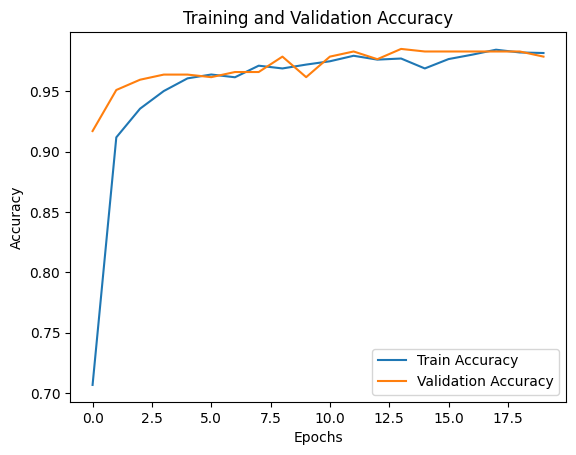

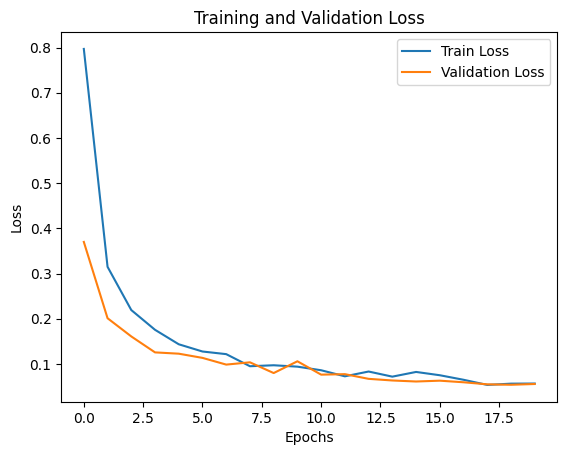

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step


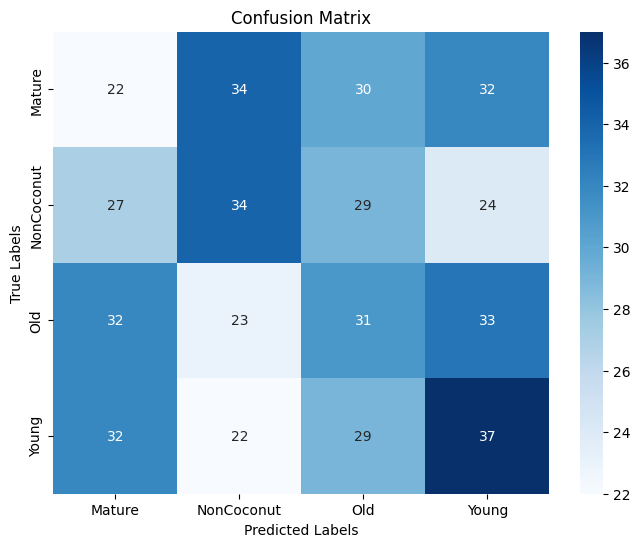

Classification Report:
              precision    recall  f1-score   support

      Mature       0.19      0.19      0.19       118
  NonCoconut       0.30      0.30      0.30       114
         Old       0.26      0.26      0.26       119
       Young       0.29      0.31      0.30       120

    accuracy                           0.26       471
   macro avg       0.26      0.26      0.26       471
weighted avg       0.26      0.26      0.26       471

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


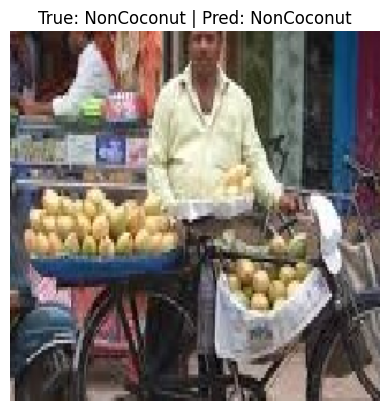

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


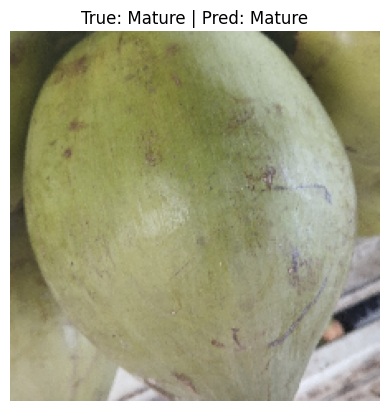

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


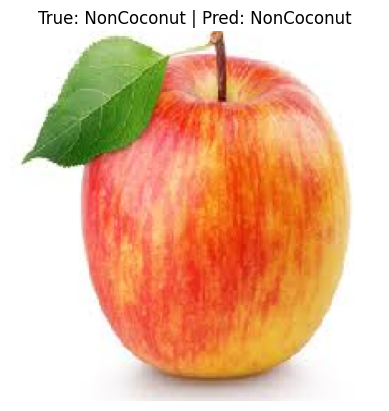

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


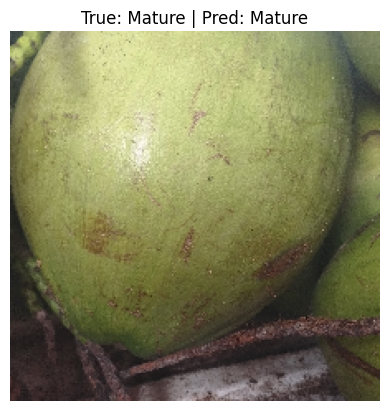

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


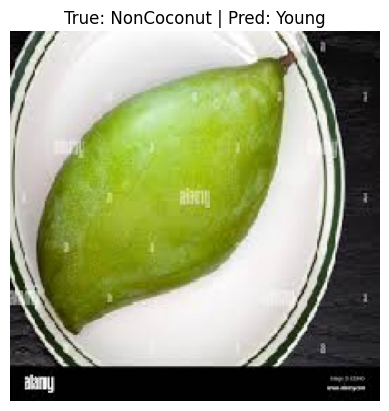

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


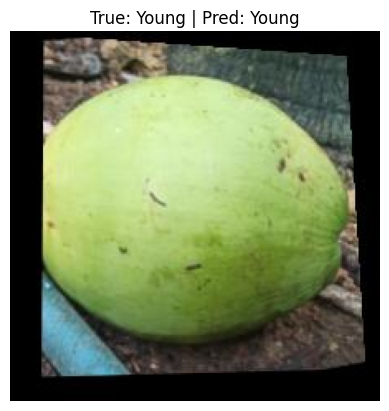

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


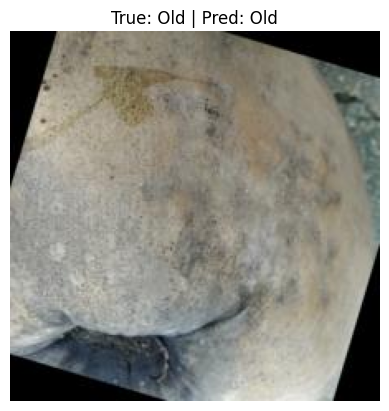

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


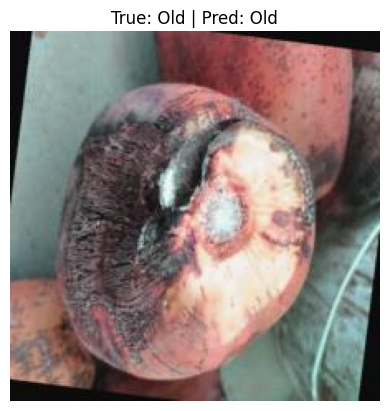

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


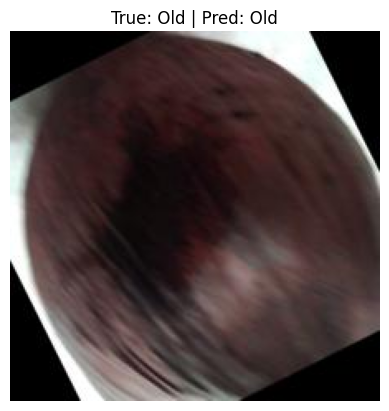

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


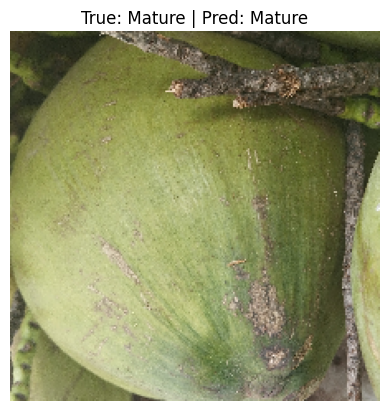

In [10]:
# Confusion Matrix
# Predict the classes on the test set
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# True vs. Predicted Visualization
# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Iterate over the test generator
for i, (img, label) in enumerate(test_generator):  # Unpack batches from the generator
    if i >= 10:  # Show only the first 10 test images
        break

    # Predict the class
    pred = model.predict(img)
    pred_label = class_labels[np.argmax(pred[0])]
    true_label = class_labels[np.argmax(label[0])]

    # Display the image
    plt.imshow(img[0])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()